In [2]:
import matplotlib.pyplot as plt


In [2]:
!pip install kaggle  # Install Kaggle CLI if not installed
from google.colab import files

# Upload your Kaggle API key (kaggle.json)
files.upload()

# Move kaggle.json to the right location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c deep-learning-spring-2025-project-1
!unzip deep-learning-spring-2025-project-1.zip -d /content/

# Update the path in your code
cifar10_dir = '/content/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

Saving kaggle.json to kaggle.json
 99% 188M/189M [00:00<00:00, 331MB/s]
100% 189M/189M [00:00<00:00, 317MB/s]
Archive:  deep-learning-spring-2025-project-1.zip
  inflating: /content/cifar-10-python/cifar-10-batches-py/batches.meta  
  inflating: /content/cifar-10-python/cifar-10-batches-py/data_batch_1  
  inflating: /content/cifar-10-python/cifar-10-batches-py/data_batch_2  
  inflating: /content/cifar-10-python/cifar-10-batches-py/data_batch_3  
  inflating: /content/cifar-10-python/cifar-10-batches-py/data_batch_4  
  inflating: /content/cifar-10-python/cifar-10-batches-py/data_batch_5  
  inflating: /content/cifar-10-python/cifar-10-batches-py/readme.html  
  inflating: /content/cifar-10-python/cifar-10-batches-py/test_batch  
  inflating: /content/cifar_test_nolabel.pkl  


In [3]:
pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
!unzip -q /content/deep-learning-spring-2025-project-1.zip -d /content/

replace /content/cifar-10-python/cifar-10-batches-py/batches.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_dir = '/content/cifar-10-python/cifar-10-batches-py/'

meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0)
])

class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
val_labels = np.array(batch_test_dict[b'labels'])

val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

cifar_test_path = '/content/cifar_test_nolabel.pkl'

test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0
#test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        identity = self.skip(identity)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 64, 4, stride=1)
        self.layer2 = self._make_layer(64, 128, 5, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.5)  # Dropout placed AFTER FC


    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)

        out = self.dropout(out)  # Apply dropout before FC layer

        out = self.fc(out)
        return out


# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()
# predictions = []
# with torch.no_grad():
#     for batch in test_loader:
#         images = batch[0].to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         predictions.extend(predicted.cpu().numpy())

Mounted at /content/drive
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model = CustomResNet().to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
trainable_params

6173258

In [7]:
import matplotlib.pyplot as plt

model = CustomResNet().to(device)

def train_model(model, train_loader, val_loader, epochs=100):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, epochs=100)

Epoch 1, Train Loss: 1.9329, Val Loss: 2.4114, Train Acc: 32.94%, Val Acc: 31.22%
Epoch 2, Train Loss: 1.5619, Val Loss: 1.4607, Train Acc: 51.21%, Val Acc: 56.84%
Epoch 3, Train Loss: 1.3760, Val Loss: 1.2719, Train Acc: 60.79%, Val Acc: 66.41%
Epoch 4, Train Loss: 1.2597, Val Loss: 1.2010, Train Acc: 66.47%, Val Acc: 69.83%
Epoch 5, Train Loss: 1.1664, Val Loss: 1.1048, Train Acc: 71.02%, Val Acc: 73.94%
Epoch 6, Train Loss: 1.0929, Val Loss: 1.1234, Train Acc: 74.59%, Val Acc: 73.70%
Epoch 7, Train Loss: 1.0364, Val Loss: 0.9740, Train Acc: 77.21%, Val Acc: 79.98%
Epoch 8, Train Loss: 0.9957, Val Loss: 0.9433, Train Acc: 78.96%, Val Acc: 81.12%
Epoch 9, Train Loss: 0.9633, Val Loss: 0.9694, Train Acc: 80.44%, Val Acc: 80.45%
Epoch 10, Train Loss: 0.9347, Val Loss: 0.9367, Train Acc: 81.66%, Val Acc: 81.57%
Epoch 11, Train Loss: 0.9088, Val Loss: 0.8856, Train Acc: 82.91%, Val Acc: 83.66%
Epoch 12, Train Loss: 0.8896, Val Loss: 0.9036, Train Acc: 83.55%, Val Acc: 83.44%
Epoch 13, Tra

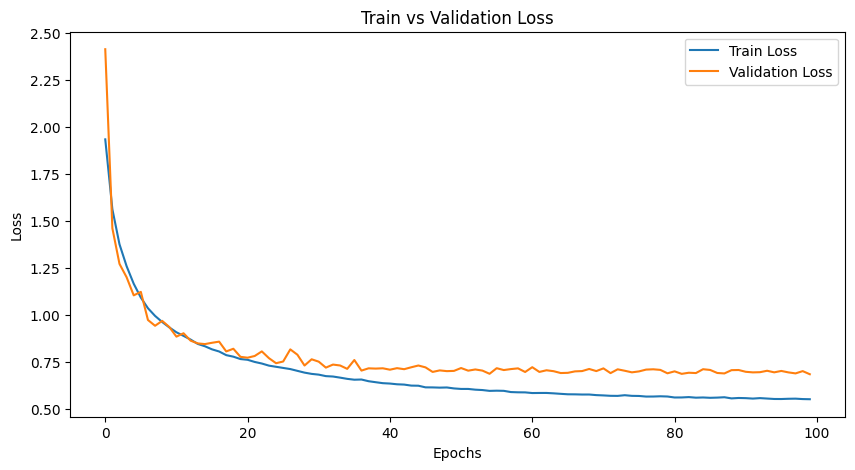

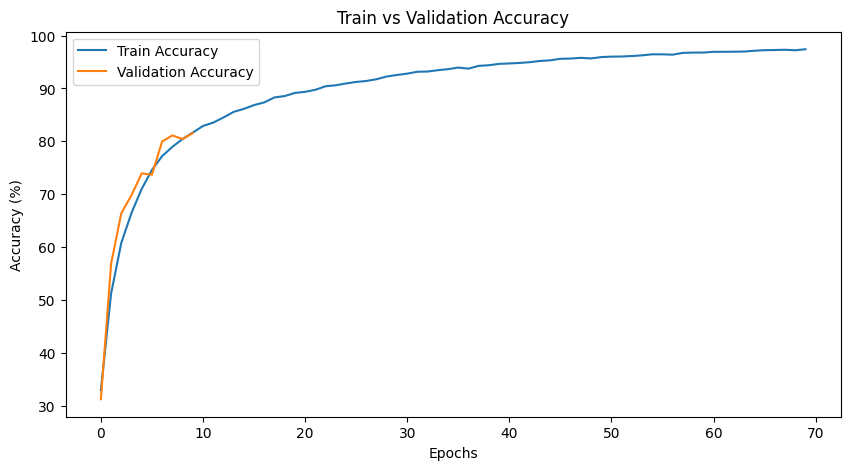

In [8]:
  # Plotting loss
  plt.figure(figsize=(10,5))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Train vs Validation Loss')
  plt.show()

  # Plotting accuracy
  plt.figure(figsize=(10,5))
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()
  plt.title('Train vs Validation Accuracy')
  plt.show()

